This is a tutorial on simple random number generation. The goal of a quantum random number generator (QRNG) is to be able to use true randomness, in opposition to classical RNG, or Pseudo-Random Number generator, where a deterministic algorithm is executed. Some PRNG are able to produce enough randomness for critical applications, and we call them cryptographically secure PRNG. But it's still not random generation, and a seed is needed for these algorithms.

That's why, in order to secure the most crucial data, we want a QRNG. We don't need it for everyday's applications in cryptography, but for sensitive data.

Here, we want to exploit the most simple form of randomness from the Quantum computers: each Qubit will be random so at each measure, a new random number is generated. The number of bits for the generated random number is exactly the number of Qubits, so each new Qubit added doubles the amount of possible outcome. 

In [1]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit import QuantumCircuit, execute, Aer, IBMQ

import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
%matplotlib inline

# Loading your IBM Q account(s)
IBMQ.load_accounts()

We want to generate random numbers in a range, so we need a function to map a given value to the desired interval.

In [2]:
def real_map(value, leftMin, leftMax, rightMin, rightMax):
    # Maps one range to another
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

Now, we define the function that will create the circuit, and run it on the selected backend. The circuit is really simple, we only want each bit associated to each Qubit to be generated randomly. The law of the random variable giving the output of the measurment of the circuit is just the uniform law $\mathcal{U}(0,2^n)$, with $n$ the number of qubits.

In [3]:
def QRandom(a, b, qubits=2, shots=1, backend=None):
    # Quantum Random Number generator
    q = QuantumRegister(qubits, 'q')
    c0 = ClassicalRegister(qubits, 'c0')
    circ = QuantumCircuit(q, c0)
    circ.h(q)
    circ.measure(q, c0)
    
    # default backend
    if backend is None:
        backend = Aer.get_backend('qasm_simulator')
    
    # backend with memory
    if backend.configuration().memory:
        job = execute(circ, backend, shots=shots, memory=True)
        result = job.result()
        generated_nbr = result.get_memory()
    # backend without memory: the random order is lost but the numbers are random
    else:
        job = execute(circ, backend, shots=shots)
        result = job.result()
        output = result.get_counts()
        generated_nbr = []
        for key in output.keys():
            for _ in range(output[key]):
                generated_nbr.append(key)
        shuffle(generated_nbr)
    
    return [real_map(int(nbr,2), 0, 2**qubits, a, b) for nbr in generated_nbr]

We can test the function with the simulator. The way the simulator works makes it a PRNG for now: it's a PRNG that generated the results from the measure. But we have an idea of what it will return. The parameters of the function are the interval of sample, the number of Qubits, the desired amount of generated numbers, and the backend selected for the job. By default, the backend is the simulator. 

[43.75, 93.75, 18.75, 90.625, 31.25, 87.5, 9.375, 46.875, 12.5, 9.375, 59.375, 46.875, 75.0, 40.625, 75.0, 46.875, 53.125, 65.625, 78.125, 75.0]


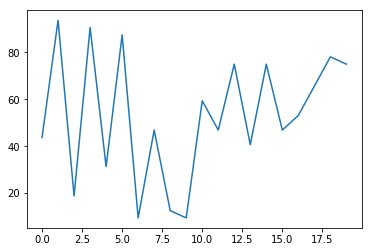

In [4]:
x = QRandom(0, 100, 5, 20) 
print(x)
plt.plot(x)

But the interesting thing here is to generate random numbers. We can look at the list of operational backends by doing:

In [5]:
IBMQ.backends(operational=True, simulator=False)

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>]

This first backend is a 5 Qubits Quantum Computer. We can give it to the QRNG, and it will generate real random numbers.

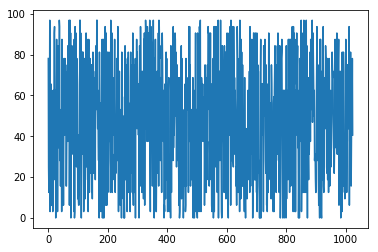

In [6]:
backend = IBMQ.get_backend('ibmqx4')
x = QRandom(0, 100, 5, 1024, backend)
plt.plot(x)

This other backend has a particularity: we can't access the order in which the numbers were generated, the memory. The numbers are still random, but a PRNG is used to generate the time of generation. However, it can generate precise random numbers, because we can use all 14 Qubits from it, and so have a precision of 14 bits for the generation. 

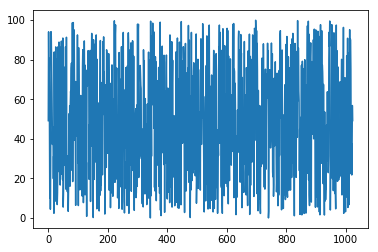

In [7]:
backend = IBMQ.get_backend('ibmq_16_melbourne')
x = QRandom(0, 100, 10, 1024, backend)
plt.plot(x)

In conclusion, it's surprisingly easy to generate true random numbers using a Quantum Computer. Because it's such a simple circuit, even a bad quantum computer can run this code, but keep in mind it's only uniform generation. Other, and more complex, random laws can be generated by a Quantum Computer.